---
comments: true
layout: post
title: Deployment using Login and Authorization Code 
description: This Tech Talk is to transition your project from a local development environment to a live server. We will be using AWS, EC2, Docker, Nginx, and Certbot to deploy your project. This project will review login and authorization code as guide to the deployment process, as this code supports the most common use cases and considerations for deploying a project. 
courses: { compsci: {week: 13} }
type: tangibles
---

## Full Stack and Deployment Introduction 

This blog describes a project that will be developed on localhost and then deployed to a publicly available web server. Here are some key elements that need solutions and consideration:

- **JavaScript Fetch, URI**: The project must manage the switch between development and deployment URI access for frontend requests. This is achieved by including the `assets/js/config.js` file in the `teacher_portfolio` project. This file should be referenced whenever a URL endpoint fetch is performed.

- **JavaScript Fetch, Credentials, and Cookies**: The project's APIs must consistently handle authorization options. This involves setting the fetch mode to 'cors' and including credentials in the fetch options. This setup enables cookies to be passed between the frontend and backend during requests, facilitating user authentication and session management. These options are defined by including the `assets/js/config.js` as well.

- **Nginx, Credentials, and Cookies**: For deployment and cookie handling, the project's authorization credentials need to be defined in the Nginx configuration. This is done by setting the `Access-Control-Allow-Credentials` directive in the `/etc/nginx/sites-available` application configuration file.

- **Nginx and CORS**: For deployment, CORS policies need to be configured in Nginx. This involves setting the `Access-Control-Allow-Origin` directive in the `/etc/nginx/sites-available` application configuration file.

- **Nginx and HTTP Methods**: For deployment, the HTTP methods (GET, POST, PUT, DELETE) that the application uses need to be allowed in the Nginx configuration. This is done by setting the `Access-Control-Allow-Method` directive in the `/etc/nginx/sites-available` application configuration file.

- **Python, CORS**: For both localhost development and deployment, the project needs to consider Cross-Origin Resource Sharing (CORS). The CORS policies should be built into the Python code, specifically in your `__init__.py` file. This setup allows the necessary access between your frontend and backend, supporting both development and deployment environments.  **Note**, remove similar code from main.py if you picked up an old version from Teacher.

- **Python, instance data**: In your `__init__.py` file, you need to configure the settings for your database and uploads. These settings should ensure that data and files persist outside of the Docker container. If not correctly configured, any data stored in the database or any files uploaded will be lost when the Docker container is stopped.

- **Python, authentication and authorization**: In this implementation, the decorator `@token_required` is used to guard HTTP endpoints. This uses the allowed credentials which send the cookie to the application. The application unwraps the cookie and uses the user id to query and return the user object from the database. The user object can be used in the application logic of the API to identify the request to the owner.

- **Python, CSRF**: When deploying your server, it's crucial to manage secret keys for CSRF (Cross-Site Request Forgery) `__init__.py` file. This secret key is used to generate unique tokens that help protect your application against CSRF attacks.

- **Certbot, HTTPS**: For deployment security, using HTTPS is crucial to prevent sensitive information from being intercepted over the internet. Certbot is the tool of choice used in this project to automate the process of obtaining and installing SSL/TLS certificates. Running `sudo certbot --nginx` will modify the Nginx configuration to redirect HTTP requests to HTTPS, enhancing the security of your application. It's important to note that this step is vital for maintaining the integrity and confidentiality of data in transit. Always verify the configuration change after running the command.

These considerations are crucial for successfully deploying a web application from localhost to a live server. They ensure your application remains functional and secure in the new environment.

## Login and Security in Python / Flask project
A big portion of any deployed frontend to backend project is to enable User login and security. This project is using JSON Web Tokens (JWT) to enable and guard endpoints according authentication and authorization.   

- ***Login Request***. The frontend receives the user's ID and password as input and performs an HTTP POST request to log in and authenticate the user.

- ***Login Response***.  The backend validates the credentials against the stored database and prepares a JSON response with the authentication status, e.g., 'Login success' with a 200 status code, or 'Bad request' with a 400 status code.

- ***JWT cookie***. If the login is successful, the backend returns a JWT that is stored in the web browser as a cookie. Subsequent requests to the server will include this JWT in the credentials. 

- ***Security decorator***.  Python endpoints in the backend that require login credentials will be protected with the @token_required decorator.

- ***User credentials***.  The backend endpoint code can use the return values from the @token_required decorator to control logic based on the user's ID and their authorization level.

### Uses of HTTP requests in Login and Authorization
The following requests methods are common to a user based system.  These methods can be open or guarded using authentication and authorization based on logged in user.

- Unguarded requests
  - POST request for signing up and creating new users.
  - POST request for logging in and authorizing users.

- Guarded requests, @token_required
  - GET request(s) for fetching user data from the system.
  - PUT request for updating user information, which requires user or admin authentication.
  - DELETE request for removing a user from the database, which requires admin authentication.

## Frontend to Backend code examples
Transitioning from a localhost to a deployed project requires a solid understanding of key system elements.
To have the ability to transition from localhost to deployed project, it is important to understand key elements of the system.  These examples focus on user and login functionalities, which are the starting points of a project and provide valuable insights into common coding techniques and considerations.

### Common URI and Header options
To facilitate consistency in fetch operations, it's best to isolate variables into a single location. This code should be imported and used as a template for every fetch operation.

In [ ]:
// The URI used in fetch is determined by the hostname of the requester.
export var uri;
if (location.hostname === "localhost") {
        uri = "http://localhost:8086";
} else if (location.hostname === "127.0.0.1") {
        uri = "http://127.0.0.1:8086";
} else {
        uri = "https://flask2.nighthawkcodingsociety.com";
}


// A fetch header template should be used to avoid omissions or other errors, 
// (*) the atererisk is assigned, other values are shown for reference. 
export const options = {
    method: 'GET', // *GET, POST, PUT, DELETE, etc.
    mode: 'cors', // no-cors, *cors, same-origin
    cache: 'default', // *default, no-cache, reload, force-cache, only-if-cached
    credentials: 'include', // include, same-origin, omit
    headers: {
        'Content-Type': 'application/json',
    },
};

### Login User, frontend code
This method illustrates login and uses config.js as a template start the request definitions for URL and Authorization options.
- The script retrieves user and password information from the HTML form inputs.
- The script overrides options from config.js by changing the method to POST and adding the form inputs to the request.
- The script handles successful HTTP responses and errors.
  - Upon successful login, the script redirects to a database endpoint.
  - If a failure occurs, the script stays on the page and updates the form with an error message.

In [ ]:
<!-- 
A simple HTML login form that triggers a login action when the button is pressedi, login_user() function.
-->
<!-- Login Form -->
<form action="javascript:login_user()">
    <p><label>
        User ID:
        <input type="text" name="uid" id="uid" required>
    </label></p>
    <p><label>
        Password:
        <input type="password" name="password" id="password" required>
    </label></p>
    <p>
        <button>Login</button>
    </p>
    <p id="error-message" style="color: red;"></p>
</form>


<!-- 
This script handles user authentication. Upon successful authentication, 
it redirects to a page that requires a JWT (JSON Web Token) for access. 
-->
<script>
    // In the context of GitHub Pages, the Liquid site.baseurl variable is used to locate the config.js file.
    import { uri, options } from '{{site.baseurl}}/assets/js/api/config.js';

    // Set the URLs for the endpoints used in this script.
    const url = uri + '/api/users/authenticate';
    const redirect =  uri + '/python/database'; 

    // Method to login user
    function login_user(){

        // Set body to include login data from HTML form
        const body = {
            uid: document.getElementById("uid").value,
            password: document.getElementById("password").value,
        };

        // Modify the options to use the POST method and include the request body.
        const authOptions = {
            ...options, // This will copy all properties from options
            method: 'POST', // Override the method property
            cache: 'no-cache', // Set the cache property
            body: JSON.stringify(body)
        };

        // Clear any previous error messages
        document.getElementById("error-message").textContent = "";

        // Fetch the JWT object from the Web API.
        fetch(url, options)
        .then(response => {
            // trap error response from Web API
            if (!response.ok) {
                const errorMsg = 'Login error: ' + response.status;
                console.log(errorMsg);
                document.getElementById("error-message").textContent = errorMsg;
                return;
            }
            // Success!!!
            // Redirect to Database presentation page
            window.location.href = redirect;
        })
        .catch(error => {
            // Handle any network errors.
            console.log('Possible CORS or service down error: ' + error);
            document.getElementById("error-message").textContent = 'Possible CORS or service down error: ' + error;
        });
    }


</script>

### Login User - backend code
This code illustrates how the Python backend handles a login request.
- The provided Python code demonstrates the key components of building an endpoint.
- The POST method demonstrates the process of validating and obtaining the user ID and password from the JSON request.
- This section illustrates how to query the backend database to obtain a Python user object.
- At various stages, if a check fails, an error code and message are provided.
- Upon successful lookup of a user in the database, a **cookie is generated**.
  - This is returned to the frontend and becomes the **foundation for being authenticated**.
  - The generated cookie from the backend is saved in the browser and is **associated with the web server**. This association is crucial as it allows the server to recognize and authenticate the user in subsequent requests.
  - Note, it is generally best to avoid storing sensitive data in cookies.

In [ ]:
# ... imports

# blueprint for user api endpoints
user_api = Blueprint('user_api', __name__,
                   url_prefix='/api/users')
api = Api(user_api)

# ... more resource code

# api resource class for security
class _Security(Resource):
    # method to authenticate user
    def post(self):
        try:
            body = request.get_json()
            if not body:
                return {
                    "message": "Please provide user details",
                    "data": None,
                    "error": "Bad request"
                }, 400
                
            ''' Get Request Data '''
            uid = body.get('uid')
            if uid is None:
                return {'message': f'User ID is missing'}, 401
            password = body.get('password')
            
            ''' Find User ID in Database '''
            user = User.query.filter_by(_uid=uid).first()
            if user is None or not user.is_password(password):
                return {'message': f"Invalid user id or password"}, 401
            if user:
                try:
                    # Add an expiration date to the JWT token
                    token = jwt.encode(
                        {"_uid": user._uid},
                        current_app.config["SECRET_KEY"],
                        algorithm="HS256"
                    )
                    resp = Response("Authentication for %s successful" % (user._uid))
                    resp.set_cookie("jwt", token,
                            max_age=3600,
                            secure=True,
                            httponly=True,
                            path='/',
                            samesite='None'  # This is the key part for cross-site requests
                            )
                    return resp
                except Exception as e:
                    return {
                        "error": "Something went wrong in cookie creation!",
                        "message": "Failed to generate JWT token: " + str(e)
                    }, 500
            return {
                "message": "Error fetching auth token!",
                "data": None,
                "error": "Unauthorized"
            }, 404
        except Exception as e:
            return {
                    "message": "Something went wrong in data processing!",
                    "error": str(e),
                    "data": None
            }, 500

            
    # building a RESTapi endpoint
    api.add_resource(_Security, '/authenticate')

### Accessing Data, frontend code
Websites often contain public information, such as a home page or the login page we previously discussed. Additionally, websites typically contain secured information that is only available to users who have successfully logged in.  The following frontend code retrieves a list of users from a backend database. This information is only available to users who have an account.
- The HTML shows the column layout for name, id, and age of users in the database.
- The fetch code uses the config.js file. Since this is a GET request, it follows the template exactly. 
- The URL is set to the protected endpoint.
- The fetch request only proceeds if a 200 status code is received. Otherwise, it returns an error message in the HTML table.
- Additionally, the fetch request could fail if the endpoint is down or if the machine accessing the endpoint has network issues, such as a Wi-Fi outage.
- Upon success, the script extracts the body from the response and formats it to match the column layout in the HTML table..

In [ ]:
<!-- HTML table layout for the page. The table is populated by the JavaScript code below. -->
<table>
  <thead>
  <tr>
    <th>Name</th>
    <th>ID</th>
    <th>Age</th>
  </tr>
  </thead>
  <tbody id="result">
    <!-- javascript generated data -->
  </tbody>
</table>

<!-- 
The JavaScript code below fetches user data from an API and displays it in the table. i
It uses the Fetch API to make a GET request to the '/api/users/' endpoint. 
The 'uri' variable and 'options' object are imported from the 'config.js' file.

The script executes sequentially when the page is loaded.
-->
<script type="module">
  // Import 'uri' variable and 'options' object from 'config.js'
  import { uri, options } from '{{site.baseurl}}/assets/js/api/config.js';

  // Set the URL to the 'users' endpoint
  const url = uri + '/api/users/';

  // Get the HTML element where the results will be displayed
  const resultContainer = document.getElementById("result");

  // Make a GET request to the API
  fetch(url, options)
    // response is a RESTful "promise" on any successful fetch
    .then(response => {
      // If the response status is not 200, display an error message
      if (response.status !== 200) {
          const errorMsg = 'Database response error: ' + response.status;
          console.log(errorMsg);
          const tr = document.createElement("tr");
          const td = document.createElement("td");
          td.innerHTML = errorMsg;
          tr.appendChild(td);
          resultContainer.appendChild(tr);
          return;
      }
      // valid response will contain JSON data
      response.json().then(data => {
          console.log(data);
          for (const row of data) {
            // Create a new table row and cells for each piece of data
            // tr and td build out for each row
            const tr = document.createElement("tr");
            const name = document.createElement("td");
            const id = document.createElement("td");
            const age = document.createElement("td");
            // data is specific to the API
            name.innerHTML = row.name; 
            id.innerHTML = row.uid; 
            age.innerHTML = row.age; 
            // this builds td's into tr
            tr.appendChild(name);
            tr.appendChild(id);
            tr.appendChild(age);
            // Append the row to the table
            resultContainer.appendChild(tr);
          }
      })
  })
  // If the fetch request fails (e.g., due to network issues), display an error message
  .catch(err => {
    console.error(err);
    const tr = document.createElement("tr");
    const td = document.createElement("td");
    td.innerHTML = err + ": " + url;
    tr.appendChild(td);
    resultContainer.appendChild(tr);
  });
</script>

### Accessing Data, backend code
The code snippets below illustrate a guarded GET method, where @token_required is the guard.

- The GET method can fail due to the guard, most often resulting in 'Unauthorized' or 'Forbidden' responses.

- The token_required method is the guarding function and handles failure possibilities.

- If token_required is successful, it returns a user object from the database, which is based on the user ID in the token.

- The GET method and authentication enable the logged-in user to query all users from the database. The user object returned from the database is not used in this method (self, _). The underscore is a convention indicating that it is not used.

- If the security policy of your application restricts users to only viewing their own data, the method would replace the underscore with 'user' and use it in the database query.

- The GET method returns the protected user list from the database as a result of authenticated access.

In [ ]:
# from user.py file
# ... more import and blueprint code
class UserAPI:        
    class _CRUD(Resource):
        # ... more resource code omitted
        # The @token_required decorator ensures that the user is authenticated before they can access the data.
        @token_required()
        # The get method retrieves all users from the database.
        # The underscore (_) indicates that the current_user is not used in this method.
        def get(self, _): 
            users = User.query.all()    # Query all users from the database
            json_ready = [user.read() for user in users]  # Prepare the data for JSON output
            return jsonify(json_ready)  # Convert the data to a JSON response

    # Add the _CRUD resource to the API at the root endpoint ('/')
    api.add_resource(_CRUD, '/')


# from auth_middlewares.py file
# ... more import code
# The token_required function is a decorator that checks if the user is authenticated.
# If roles are provided, it also checks if the user has the required role.
def token_required(roles=None):
    def decorator(f):
        @wraps(f)
        def decorated(*args, **kwargs):
            token = request.cookies.get("jwt")  # Get the JWT token from the cookies
            # If the token is missing, return an error message
            if not token:
                return {
                    "message": "Authentication Token is missing!",
                    "data": None,
                    "error": "Unauthorized"
                }, 401
            try:
                # Decode the token and get the user's data
                data = jwt.decode(token, current_app.config["SECRET_KEY"], algorithms=["HS256"])
                current_user = User.query.filter_by(_uid=data["_uid"]).first()
                # If the user doesn't exist or doesn't have the required role, return an error message
                if current_user is None:
                    return {
                        "message": "Invalid Authentication token!",
                        "data": None,
                        "error": "Unauthorized"
                    }, 401

                # If the doesn't have the required role, return an error message
                if roles and current_user.role not in roles:
                    return {
                        "message": "Insufficient permissions. Required roles: {}".format(roles),
                        "data": None,
                        "error": "Forbidden"
                    }, 403

            # If there's an error (likely with the token), return an error message
            except Exception as e:
                return {
                    "message": "Something went wrong, likely with the token!",
                    "data": None,
                    "error": str(e)
                }, 500

            # If the user is authenticated and has the required role (if applicable), call the decorated function
            return f(current_user, *args, **kwargs)

        return decorated

    return decorator


## Developer Operation (DevOps) for Deployment
After creating a working Flask application, it can be deployed on an Ubuntu server. Here are the key steps to deployment using a publicly available tool chain.

### AWS requirements.   
Create a server, assign a public IP, and set up a DNS record.  This requires an AWS account and appropriate permissions to create and manage EC2 instances, Elastic IPs, and Route 53 records.

1. EC2. Launch an instance.
    - AMI, pick Ubuntu and an image type to match your sizing needs.
    - Create a key pair for SSH access in case of AWS console issues.
    - The security group should allow inbound traffic for SSH (port 22), HTTP (port 80), and HTTPS (port 443).
    - The security group can also allow additional access, such as Cockpit, to bypass school firewalls.

2. Elastic IP.  This is an optional step, but highly recommended, to ensure the IP address remains the same after an EC2 reboot.  Otherwise, the server will require a Domain or Subdomain update after each reboot.

3. Route 53 Domain or Subdomain.   Create a domain or subdomain. This is a prerequisite for mapping your Nginx configuration to a live server.

### Configuration files.  
Create configuration files and store them in GitHub for version control.

1. Docker.  Create a Docker file and docker-compose.yml file.
    - Builds the Python application.
    - Mounts to perisistent volumes. The "instance" path is a standard location for SQLite.db database or file Uploads.
    - Exposes a port to the running python application to system
    
2. Nginx. Create an Nginx configuration, this will be moved from project directory to /etc/nginx/sites-available.
    - Listens for DNS domain or sub domain request from the internet
    - Reverse proxies the DNS request to the web application port exposed by Docker
    - Allows access to the servers specified in its configuration, protecting applicaton to perform CORS only on specificied resources.
    - Allows access to the HTTP methods specified in its configuration

3. Python. The application manages settings in the "_init_.py".
    - Allows access to the servers and IP addresses in the configuration, enabling CORS to specified resources.
    - Specifies location for database and uploads so they are outside of the Docker container, in the instance directory.



### Sample Docker file

```Dockerfile
# Use the official Python 3.10 image from Docker Hub as the base image
FROM docker.io/python:3.10

# Set the working directory to the root of the Docker container
WORKDIR /

# Update the system packages and install Python3, pip, and git
RUN apt-get update && apt-get upgrade -y && \
    apt-get install -y python3 python3-pip git

# Copy the local files into the Docker container
COPY . /

# Install the Python dependencies specified in requirements.txt
RUN pip install --no-cache-dir -r requirements.txt

# Install gunicorn, a WSGI HTTP server for Python web applications
RUN pip install gunicorn

# Set the command line arguments for gunicorn
# --workers=1: Use 1 worker process
# --bind=0.0.0.0:8086: Bind the server to all available network interfaces and use port 8086
ENV GUNICORN_CMD_ARGS="--workers=1 --bind=0.0.0.0:8086"

# Expose port 8086 to the host machine, allowing external access to the application
EXPOSE 8086

# Start the gunicorn server when the container is run, using the application defined in main.py
CMD [ "gunicorn", "main:app" ]
```

### Sample docker-compose.yml

```yml
# Specify the Docker Compose file version
version: '3'

# Define the services that make up your app
services:
    # The 'web' service is your Flask application
    web:
        # Name of the Docker image to be built for the 'web' service
        image: flask_portfolio_v1
        # Build the Dockerfile in the current directory
        build: .
        # Map port 8286 on the host to port 8086 in the container
        ports:
                - "8286:8086"
        # Mount the 'instance' directory from the host to '/instance' in the container
        # This allows the container to access the data in the 'instance' directory
        volumes:
                - ./instance:/instance
        # Automatically restart the container if it crashes, unless it was manually stopped
        restart: unless-stopped
```

### Sample Nginx configuration file

```nginx
# This block defines a server that listens on port 80
server {
    # Listen for incoming connections on port 80 for both IPv4 and IPv6
    listen 80;
    listen [::]:80;

    # DNS. The server_name directive 
    server_name flask2.nighthawkcodingsociety.com;

    # This block defines how to respond to requests for the root location ("/")
    location / {
        # Port. The proxy_pass directive sets the protocol and address of the proxied server
        proxy_pass http://localhost:8286;

        # This block handles preflighted requests (HTTP OPTIONS method)
        if ($request_method = OPTIONS) {
            # Cookies. This allows the browser to include credentials in the request
            add_header "Access-Control-Allow-Credentials" "true" always;

            # CORS. This specifies the cross origin that is allowed to access the resource
            add_header "Access-Control-Allow-Origin"  "https://nighthawkcoders.github.io" always;

            # Methods. This specifies the methods that are allowed when accessing the resource
            add_header "Access-Control-Allow-Methods" "GET, POST, PUT, OPTIONS, HEAD" always;

            # This specifies how long the results of a preflight request can be cached
            add_header "Access-Control-Allow-MaxAge" 600 always;

            # This specifies the headers that are allowed in the actual request
            add_header "Access-Control-Allow-Headers" "Authorization, Origin, X-Requested-With, Content-Type, Accept" always;

            # This indicates that the server has successfully fulfilled the request and there is no additional content to send in the response payload body
            return 204;
        }

    }
}
```

### Sample _init.py_ file

```python
from flask import Flask
from flask_cors import CORS
from flask_sqlalchemy import SQLAlchemy
from flask_migrate import Migrate
import os

"""
These object can be used throughout project.
1.) Objects from this file can be included in many blueprints
2.) Isolating these object definitions avoids duplication and circular dependencies
"""

# Setup of key Flask object (app)
app = Flask(__name__)
# Allowed servers for cross-origin resource sharing (CORS)
cors = CORS(app, supports_credentials=True, origins=['http://localhost:4100', 'http://127.0.0.1:4100', 'http://127.0.0.1:8086', 'https://nighthawkcoders.github.io'])

# Secret key for session handling and CSRF protection
SECRET_KEY = os.environ.get('SECRET_KEY') or 'SECRET_KEY'
app.config['SECRET_KEY'] = SECRET_KEY

# Setup SQLAlchemy object and properties for the database (db)
# Local SQLite database within the instance folder
dbURI = 'sqlite:///volumes/sqlite.db'
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
app.config['SQLALCHEMY_DATABASE_URI'] = dbURI
db = SQLAlchemy()
Migrate(app, db)

# Images storage settings and location
app.config['MAX_CONTENT_LENGTH'] = 5 * 1024 * 1024  # maximum size of uploaded content
app.config['UPLOAD_EXTENSIONS'] = ['.jpg', '.png', '.gif']  # supported file types
app.config['UPLOAD_FOLDER'] = os.path.join(app.instance_path, 'uploads')
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)
```

## Relationship of Full Stack and Deployment to College Board questions
This final section helps you build a mental map between work you are doing and the questions you will be responsible to answer on the College Board exam.

### How computers send and receive information using computer systems, computer networks, and packets.
In the context of a Full Stack application, the process of sending and receiving information is fundamental. Whether it's a user logging in, submitting a form, or retrieving data, information is constantly being exchanged between the client and the server.

1. How computer systems and networks facilitate the transfer of data?  
The Full Stack application is a perfect example of how computer systems and networks facilitate data transfer. The frontend sends requests to the backend over the network, the backend processes these requests and sends responses back to the frontend. 

- JavaScript Fetch, URI, Credentials, and Cookie. The JavaScript fetch API is used to send requests from the frontend to the backend, and the responses are received and processed. The use of credentials and cookies is part of the HTTP protocol, which is an Internet protocol used to standardize how requests and responses are formatted and transmitted over the Internet.

- Nginx, Credentials, Cookies, CORS, and HTTP Methods: These points also relate to how computers send and receive information. Nginx is a web server that handles incoming requests and sends responses. The configuration of Nginx determines how requests are processed, including which HTTP methods are allowed, how CORS policies are handled, and how cookies and credentials are managed.

2. How information is transmitted on the Internet?
When you deploy your application to a server, it becomes accessible on the Internet. Users send requests to your server over the Internet, and your server sends responses back over the Internet.

- Python, CORS, instance data, CSRF: These points relate to how information is processed on the server side. CORS policies determine how requests from different origins are handled. Instance data and CSRF protection are important aspects of managing data and security on the server.

3. Purpose of Internet protocols.
Internet protocols like HTTP and HTTPS are used to standardize how requests and responses are formatted and transmitted over the Internet. They also define how to handle errors and security. For instance, when a user submits a login form, the browser uses the HTTP protocol to send a POST request to the server. The server then responds with a status code, such as 200 for success or 401 for unauthorized, according to the HTTP protocol.

- Certbot, HTTPS: This point relates to the purpose of Internet protocols. HTTPS is an Internet protocol that provides secure communication over a computer network. Certbot is a tool used to obtain and install SSL/TLS certificates, which are required for HTTPS.

- SSL/TLS certificates are digital certificates that use public key cryptography to establish a secure connection between a client (e.g., a web browser) and a server (e.g., a deployed backend). They contain a public key for encrypting data and are issued by a trusted Certificate Authority (CA). The corresponding private key, kept secure on the server, is used to decrypt the data. This mechanism ensures that the data transferred between the client and server remains confidential and integral.

4. Relationship between Internet and World Wide Web.
The Internet is the infrastructure that allows computers to connect and communicate. The World Wide Web is a service that operates over the Internet, and it's what your users interact with when they use your deployed application.

### Look at different network solutions that are fault-tolerant and how that facilitates the transfer of data.
Fault tolerance is a crucial aspect of any network solution, especially in a production environment. It ensures that your application remains accessible even when certain components fail. Let's explore how deploying your application on a cloud service like AWS can provide fault tolerance and facilitate the smooth transfer of data.

1. Ability for network to provide fault tolerance.
Deploying your application on a cloud service like AWS can provide fault tolerance. If your server goes down, AWS can automatically start a new one.

2. How fault tolerance is achieved?
Fault tolerance can be achieved through various methods like redundancy, where multiple instances of your application are running simultaneously, and if one fails, the others continue to operate. For example, in AWS you can use Elastic Load Balancer and Auto Scaling to distribute incoming traffic across multiple instances and automatically adjust capacity to maintain steady, predictable performance.

- Fault Tolerance includes the importance of data and file persistence outside of the Docker container. This is a form of fault tolerance, as it ensures that data is not lost if the Docker container is stopped.  Additionally, the instance data can be placed in a AWS S3 with EBS (Elastic Block Store) or database in RDS (Relational Database System) for snapshots of data.

3. How the Internet is fault-tolerant?
The Internet is inherently fault-tolerant due to its decentralized nature. If one path between two computers is unavailable, the data can be routed through a different path.

### How parallel and distributed computing leverage multiple computers to solve complex problems or process large data sets more quickly.
In the world of web applications, efficiency is key. Users expect quick responses and seamless experiences. One way to achieve this is through parallel and distributed computing, which allows us to leverage the power of multiple computers to process requests more quickly. Let's delve into how this concept applies to a Full Stack application.

Parallel and Distributed Computing are inherent in the architecture of a full stack application. The frontend and backend of the application can be considered as distributed systems that operate in parallel. The backend may also use parallel processing to handle multiple requests simultaneously.

1. Ability of parallel solution to improve efficiency.
In the context of a Full Stack application, parallel processing can be used to handle multiple requests simultaneously, improving the efficiency of your application. For instance, Gunicorn, a Python WSGI HTTP Server, can spawn multiple worker processes to handle incoming requests. Each worker process can handle one request at a time, so having multiple workers allows your application to handle multiple requests in parallel.

2. Assign parallel processes to optimize speed.
Your server can be configured to handle multiple requests in parallel, which can significantly improve response times, especially under heavy load.

3. Difference between run in parallel or in sequence
Running tasks in parallel means they're all running at the same time, while running them in sequence means they run one after the other. In the context of a server, handling requests in parallel can provide much faster response times than handling them in sequence.

# IP Quiz Review

Score: 28/30


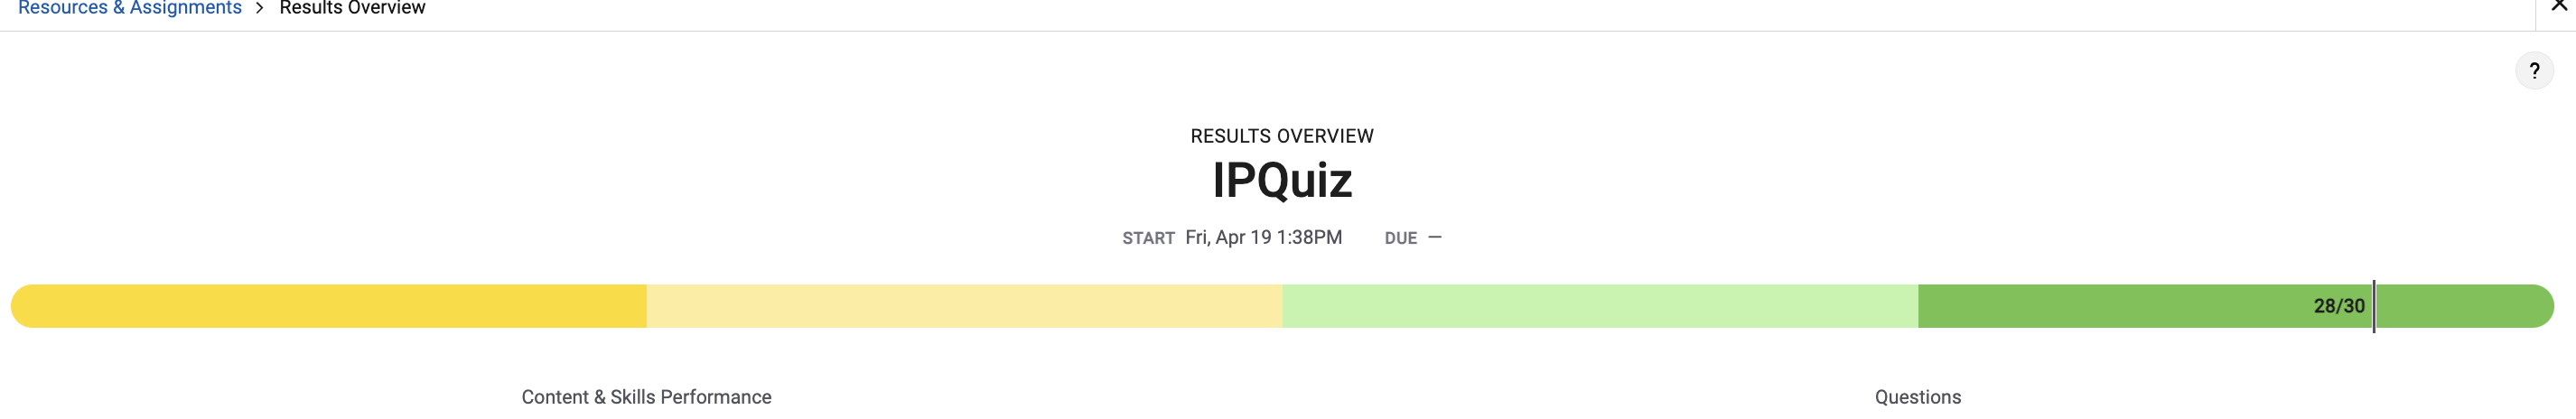





